In [1]:
# Current directory
import os
os.chdir('F:\Work\Experiment\pLM4ACE\model')

### 导入数据

In [3]:
import numpy as np
import pandas as pd

X_new = pd.read_csv(r"fusion_features\Data\features_select\PCA_All.csv", index_col=False, header=None)
y_new = pd.read_csv("fusion_features\Data\label.csv", index_col=False, header=None)

print(X_new.shape)
print(y_new.shape)
print(np.count_nonzero(y_new==0))
print(np.count_nonzero(y_new==1))

X_new = np.array(X_new)
y_new = np.array(y_new)

(1020, 800)
(1020, 1)
394
626


### 测试

Epoch 1/60
12/12 [==============================] - 2s 5ms/step - loss: 0.7417 - binary_accuracy: 0.5967
Epoch 2/60
12/12 [==============================] - 0s 4ms/step - loss: 0.4791 - binary_accuracy: 0.8038
Epoch 3/60
12/12 [==============================] - 0s 4ms/step - loss: 0.3473 - binary_accuracy: 0.8951
Epoch 4/60
12/12 [==============================] - 0s 4ms/step - loss: 0.2369 - binary_accuracy: 0.9523
Epoch 5/60
12/12 [==============================] - 0s 4ms/step - loss: 0.1543 - binary_accuracy: 0.9768
Epoch 6/60
12/12 [==============================] - 0s 4ms/step - loss: 0.0963 - binary_accuracy: 0.9823
Epoch 7/60
12/12 [==============================] - 0s 5ms/step - loss: 0.0581 - binary_accuracy: 0.9959
Epoch 8/60
12/12 [==============================] - 0s 4ms/step - loss: 0.0394 - binary_accuracy: 0.9946
Epoch 9/60
12/12 [==============================] - 0s 4ms/step - loss: 0.0206 - binary_accuracy: 1.0000
Epoch 10/60
12/12 [==============================] - 0s

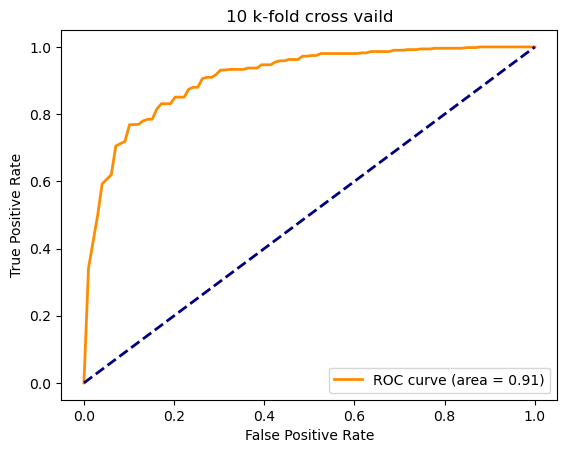

In [4]:
# 10折交叉验证
import statistics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Flatten
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
X_train_whole, X_ind_test, y_train_whole, y_ind_test =  train_test_split(X_new, y_new, test_size=0.2, random_state=1111)

# train_set = scale(X_train_whole)
[sample_num, input_dim] = np.shape(X_train_whole)
X = X_train_whole

y = y_train_whole
out_dim=2


BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
AP=[]

mean_recall = np.linspace(0, 1, 100)
all_precision = []
base_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
# 新的TPR集合
interp_tpr_collection = []

# model
def DNN(input_dim,out_dim):
    model = Sequential()
    model.add(Dense(int(64), activation='relu', kernel_initializer='glorot_normal', name='High_dim_feature_1', input_shape=(input_dim, )))
    model.add(Dropout(0.05))
    model.add(Dense(int(64), activation='relu', kernel_initializer='glorot_normal', name='High_dim_feature_2'))
    model.add(Dropout(0.05))
    model.add(Flatten())
    model.add(Dense(int(32), activation='relu', kernel_initializer='glorot_normal', name='High_dim_feature'))
    model.add(Dropout(0.05))
    model.add(Dense(2, activation='softmax', name='output'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['binary_accuracy'])#rmsprop
    return model


def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)


def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int')
    if not nb_classes:
        nb_classes = np.max(y)+1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return Y

skf = StratifiedKFold(n_splits=10)
for train, test in skf.split(X, y):
    X_train, X_valid, y_train, y_valid = np.take(X, train.tolist(), axis=0), np.take(X, test.tolist(), axis=0), np.take(y, train.tolist(), axis=0), np.take(y, test.tolist(), axis=0)
    
    y_train = to_categorical(y_train)

    clf = DNN(input_dim, out_dim)
    hist = clf.fit(X_train, y_train, batch_size=64, epochs=60)
    y_score = clf.predict(X_valid)
    y_class = categorical_probas_to_classes(y_score)
    TP, FP, FN, TN = confusion_matrix(y_valid, y_class).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))
    # ROC curve
    fpr, tpr, _ = roc_curve(y_valid, y_score[:, 1])
    interp_tpr = np.interp(base_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr_collection.append(interp_tpr)
    auc_roc = auc(fpr, tpr)
    AUC_collecton.append(auc_roc)
    # PR curve
    precision, recall, _ = precision_recall_curve(y_valid, y_score[:, 1])
    average_precision = average_precision_score(y_valid, y_score[:, 1])
    recall = np.flipud(recall)
    precision = np.flipud(precision)

    mean_precision = np.interp(mean_recall, recall, precision)
    all_precision.append(mean_precision)
    AP.append(average_precision)

# 输出结果
print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
print(round(statistics.mean(AUC_collecton),3),'±',round(statistics.stdev(AUC_collecton),3))
print(round(statistics.mean(AP),3),'±',round(statistics.stdev(AP),3))

# 在所有交叉验证循环结束后，计算TPR的均值
mean_tpr = np.mean(interp_tpr_collection, axis=0)
mean_tpr[-1] = 1.0

# Calculate the mean precision
mean_precision = np.mean(all_precision, axis=0)

# 保存ROC曲线相关参数
np.savez(r'Draw graphics\ROC curve\PCA_All\DNN_cross_vaild.npz', fpr=base_fpr, tpr=mean_tpr, roc_auc=AUC_collecton)

# 保存PR曲线相关参数
np.savez(r'Draw graphics\PR curve\PCA_All\DNN_cross_vaild.npz', recall=mean_recall, precision=mean_precision, average_precision=AP)

# 绘制ROC曲线
plt.figure()
lw = 2
plt.plot(base_fpr, mean_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % np.mean(AUC_collecton))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10 k-fold cross vaild')
plt.legend(loc="lower right")
plt.show()

Epoch 1/60
13/13 [==============================] - 0s 5ms/step - loss: 0.8189 - binary_accuracy: 0.5993
Epoch 2/60
13/13 [==============================] - 0s 4ms/step - loss: 0.5688 - binary_accuracy: 0.7475
Epoch 3/60
13/13 [==============================] - 0s 4ms/step - loss: 0.4535 - binary_accuracy: 0.8370
Epoch 4/60
13/13 [==============================] - 0s 4ms/step - loss: 0.3406 - binary_accuracy: 0.8983
Epoch 5/60
13/13 [==============================] - 0s 5ms/step - loss: 0.2416 - binary_accuracy: 0.9424
Epoch 6/60
13/13 [==============================] - 0s 5ms/step - loss: 0.1449 - binary_accuracy: 0.9755
Epoch 7/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0843 - binary_accuracy: 0.9841
Epoch 8/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0479 - binary_accuracy: 0.9975
Epoch 9/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0293 - binary_accuracy: 0.9975
Epoch 10/60
13/13 [==============================] - 0s

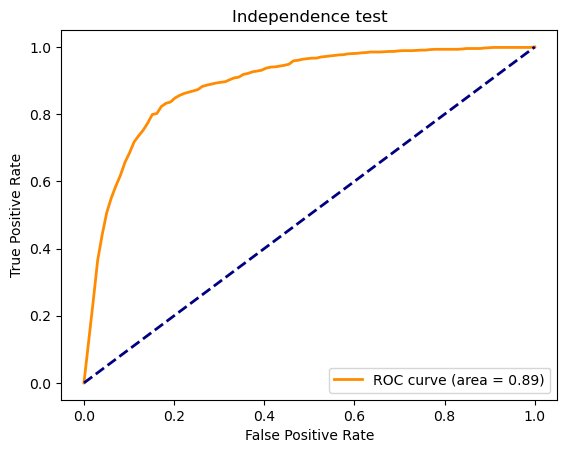

In [5]:
# 独立测试集
import statistics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Flatten
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


# train_set = scale(X_new)
[sample_num, input_dim] = np.shape(X_new)
X = X_new

y = y_new
out_dim=2

BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
AP=[]
mean_recall = np.linspace(0, 1, 100)
all_precision = []
base_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
# 新的TPR集合
interp_tpr_collection = []

# model
def DNN(input_dim,out_dim):
    model = Sequential()
    model.add(Dense(int(64), activation='relu', kernel_initializer='glorot_normal', name='High_dim_feature_1', input_shape=(input_dim, )))
    model.add(Dropout(0.05))
    model.add(Dense(int(64), activation='relu', kernel_initializer='glorot_normal', name='High_dim_feature_2'))
    model.add(Dropout(0.05))
    model.add(Flatten())
    model.add(Dense(int(32), activation='relu', kernel_initializer='glorot_normal', name='High_dim_feature'))
    model.add(Dropout(0.05))
    model.add(Dense(2, activation='softmax', name='output'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['binary_accuracy'])#rmsprop
    return model


def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)


def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int')
    if not nb_classes:
        nb_classes = np.max(y)+1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return Y

for i in range(10):
    # dataset splitting
    X_train_whole, X_ind_test, y_train_whole, y_ind_test = train_test_split(X, y, test_size=0.2, random_state=i)

    y_train = to_categorical(y_train_whole)

    clf = DNN(input_dim, out_dim)
    hist = clf.fit(X_train_whole, y_train, batch_size=64, epochs=60)
    y_score = clf.predict(X_ind_test)
    y_class = categorical_probas_to_classes(y_score)
    TP, FP, FN, TN = confusion_matrix(y_ind_test, y_class).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))
    # ROC curve
    fpr, tpr, _ = roc_curve(y_ind_test, y_score[:, 1])
    interp_tpr = np.interp(base_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr_collection.append(interp_tpr)
    auc_roc = auc(fpr, tpr)
    AUC_collecton.append(auc_roc)
    # PR curve
    precision, recall, _ = precision_recall_curve(y_ind_test, y_score[:, 1])
    average_precision = average_precision_score(y_ind_test, y_score[:, 1])
    recall = np.flipud(recall)
    precision = np.flipud(precision)

    mean_precision = np.interp(mean_recall, recall, precision)
    all_precision.append(mean_precision)
    AP.append(average_precision)

# 输出结果
print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
print(round(statistics.mean(AUC_collecton),3),'±',round(statistics.stdev(AUC_collecton),3))
print(round(statistics.mean(AP),3),'±',round(statistics.stdev(AP),3))

# 在所有交叉验证循环结束后，计算TPR的均值
mean_tpr = np.mean(interp_tpr_collection, axis=0)
mean_tpr[-1] = 1.0

# Calculate the mean precision
mean_precision = np.mean(all_precision, axis=0)

# 保存ROC曲线相关参数
np.savez(r'Draw graphics\ROC curve\PCA_All\DNN_Indenpendence.npz', fpr=base_fpr, tpr=mean_tpr, roc_auc=AUC_collecton)

# 保存PR曲线相关参数
np.savez(r'Draw graphics\PR curve\PCA_All\DNN_Indenpendence.npz', recall=mean_recall, precision=mean_precision, average_precision=AP)

# 绘制ROC曲线
plt.figure()
lw = 2
plt.plot(base_fpr, mean_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % np.mean(AUC_collecton))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Independence test')
plt.legend(loc="lower right")
plt.show()
